<h1> Link Partitioning by Partioning Around Medoids - Exact </h1>
<br/>
## Distance function: Amplified Commute Distance ##

In [1]:
import numpy as np
import random
random.seed = 108
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
from PIL import Image
from io import BytesIO
%matplotlib inline

In [50]:
import sys
!echo "p@ssw0rdController33!" | sudo -S {sys.executable} -m pip install Pillow

[sudo] password for latna: The directory '/home/latna/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/latna/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |████████████████████████████████| 2.0MB 4.6MB/s ta 0:00:01


In [2]:
!pwd

/home/latna/aponom/clustering_edited/Scripts


In [3]:
!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar

Missing required options: i, k
usage: PMPClustering <-i input_file> <-k number_of_clusters> [-ftbcd]
 -a,--algorithm <arg>      Specifies algorithm that will be used to find
                           disjoint edge clusters. Possible values:
                           pmp (p-median exact algorithm).
                           kmd (k-medoids heuristic)
                           kmn (k-means heuristic).
                           If this option is omitted, the P-Median
                           algorithm will be used.
 -b,--benchmark            use benchmark format (.dat file)
 -d,--distance <arg>       the type of function to measure the distance
                           between nodes.
                           Possible values:
                           sp (shortest path)
                           gd (Generalize Degree)
                           cm (Commute Distance)
                           acm (Amplified Commute Distance).
                           If this option is omitted

In [4]:
def lp_experiment(clustersNumber, algorithm, distance, inputFile, groundTruth, params = {}, vertexNumerationShift=0, benchmarkFormat=False, verbose=False, lineGraph=False):
    lineGraphParam = ""
    if (lineGraph == True):
        lineGraphParam = " -l"
    datasetName = inputFile.split('/')[-2]
    sufix = inputFile.split('/')[-1].split('.')[0]
    outputDir = "../Results/lp_{}_{}_{}".format(algorithm, distance, datasetName)
    outputFile = outputDir +'/' +"pmp_{3}_{2}_{0}_{1}.dat".format(algorithm, clustersNumber, distance.upper(), sufix)
    print("Output dir name: {}".format(outputDir) )
    print("Output file name: {}".format(outputFile) )
    all_results = {}
    bestParam = "not found"
    nmi_best = 0;
    param_list = list(generate_params(params))
    tmp = None
    for param in tqdm(param_list):
        if benchmarkFormat:
            tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -b -a {algorithm} -o {outputDir} -i {inputFile} -k {clustersNumber} -d {distance} -gt {groundTruth} {param}
            tmpFile = outputFile
        else:
            tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -a {algorithm} -o {outputDir} -i {inputFile} -k {clustersNumber} -d {distance} -gt {groundTruth} {param}
            lines=[]
            with open(outputFile) as f:
                lines = f.readlines()    
            tmpFile="tmpFile.dat"
            with open(tmpFile, 'w') as the_file:
                for line in lines:
                    the_file.write(" ".join([str(int(a)+vertexNumerationShift) for a in line.split()]) + "\n")

        output=!../Overlapping-NMI/onmi {groundTruth} {tmpFile}
        nmi=float(output[0].split()[1])
        all_results[param] = nmi
        if nmi >  nmi_best:
            bestParam = param
            nmi_best = nmi
    #restorign solution for the best parameters 
    if benchmarkFormat:
        tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -b -a {algorithm} -o {outputDir} -i {inputFile} -gt {groundTruth} -k {clustersNumber} -d {distance} -gt {groundTruth} {bestParam} {lineGraphParam}
        tmpFile = outputFile
    else:
        tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -a {algorithm} -o {outputDir} -i {inputFile} -gt {groundTruth} -k {clustersNumber} -d {distance} -gt {groundTruth} {bestParam} {lineGraphParam}
        lines=[]
        with open(outputFile) as f:
            lines = f.readlines()    
        tmpFile="tmpFile.dat"
        with open(tmpFile, 'w') as the_file:
            for line in lines:
                the_file.write(" ".join([str(int(a)+vertexNumerationShift) for a in line.split()]) + "\n")

    if verbose:                                                                                                                                             
        print(tmp)
    print("Best ONMI: {} params: '{}'".format(nmi_best, bestParam) )
    return all_results

In [5]:
def generate_params(params):
    keys = list(params.keys())
    if len(keys) == 1:
        for value in params[keys[0]]:
            yield ( keys[0] + " " + str(value) )        
    if len( keys ) > 1:
        for value in params[keys[0]]:
            for remain_params in generate_params({k:params[k] for k in keys[1:]}):
                yield ( keys[0] + " " + str(value) + " " + remain_params )

In [6]:
def plot_all_params(algorithm, dataset, all_results, fName=None ):
    xdata=[]
    ydata=[]
    df = pd.DataFrame()
    for param, nmi in all_results.items():
        splited = param.split()
        xdata.append(float(splited[1]))
        ydata.append(nmi)
        df = df.append({'x': float(splited[1]), 'y': nmi}, ignore_index=True)

    plt.plot(xdata, ydata, 'C3', zorder=1, lw=3)

    plt.scatter(xdata, ydata,s=70,zorder=2)
    plt.xlabel('threshold')
    plt.ylabel('onmi value');
    plt.title('Algorithm: {}\nDataset: {}'.format(algorithm, dataset));
#     if (fName is not None):
#         png1 = BytesIO()
#         plt.savefig(png1, format='png', dpi=400)
#         png2 = Image.open(png1)
#         ffName = '../figures/{}.tiff'.format(fName)
#         png2.save(ffName)
#         png1.close()
#         print("figure saved to: " + ffName)
    plt.show()

# School friendship network #

In [10]:
params={}
all_results = {}
params["-t"] = np.arange(0.05, 1.0, 0.05)

In [11]:
all_results['school'] = lp_experiment(clustersNumber=7, 
              algorithm = "pmp",
              distance = "acm",
              inputFile =  "../datasets/school_friendship/school-2.gml", 
              groundTruth = "../datasets/school_friendship/truth-school.dat", 
              params = params, 
              vertexNumerationShift=-1, 
              benchmarkFormat=False, verbose=False, lineGraph=True)


Output dir name: ../Results/lp_pmp_acm_school_friendship
Output file name: ../Results/lp_pmp_acm_school_friendship/pmp_school-2_ACM_pmp_7.dat



Best ONMI: 0.748707 params: '-t 0.55'


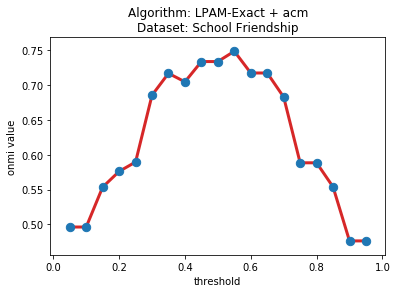

In [12]:
plot_all_params(algorithm = "LPAM-Exact + acm", 
                dataset = "School Friendship", all_results = all_results['school'], fName='lpam_onmi_school')

## Clustering results for School Frienship Netwrok with the best parameters ##

![school-2_ACM_kmd_7_out](../final_pictures/school-2_ACM_pmp_7_out.png)
## Line graph##
![school-2_ACM_kmd_7_out](../final_pictures/school-2_ACM_pmp_7_out_line.png)

# Karate Club #

In [14]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results['karate'] = lp_experiment(clustersNumber=2, 
              algorithm = "pmp",
              distance = "acm",
              inputFile =  "../datasets/karate/karate.gml", 
              groundTruth = "../datasets/karate/truth_karate.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=False,
              lineGraph=True)


Output dir name: ../Results/lp_pmp_acm_karate
Output file name: ../Results/lp_pmp_acm_karate/pmp_karate_ACM_pmp_2.dat



Best ONMI: 0.91796 params: '-t 0.45'


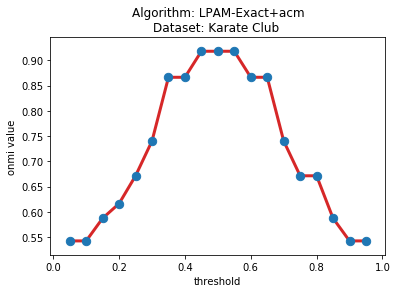

In [15]:
plot_all_params(algorithm = "LPAM-Exact+acm", dataset = "Karate Club ", all_results = all_results['karate'])

![karate_ACM_kmd_2_out](../final_pictures/karate_ACM_kmd_2_out.png)
## Line Graph ##

![karate_ACM_kmd_2_out_line](../final_pictures/karate_ACM_pmp_2_out_line.png)

# American Football League c = 12#

In [ ]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results['Fooball League'] = lp_experiment(clustersNumber=12, 
              algorithm = "kmd",
              distance = "acm",
              inputFile =  "../datasets/football/footballTSEinput.gml", 
              groundTruth = "../datasets/football/truth_footballTSEinput.dat", 
              params = params, 
              vertexNumerationShift=-1, 
              benchmarkFormat=False)

Output dir name: ../Results/lp_kmd_acm_football
Output file name: ../Results/lp_kmd_acm_football/pmp_footballTSEinput_ACM_kmd_12.dat


^C


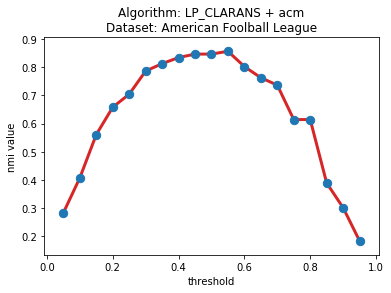

In [146]:
plot_all_params(algorithm = "LPAM-Heuristic-Clarance + acm", dataset = "American Foolball League", all_results = all_results)

### Americal Football League  [onmi: 0.856281; thresould: 0.55]

![American Football Club](../final_pictures/screenshot_235054.png)

# Adj-noun#

In [16]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results['adj-noun'] = lp_experiment(clustersNumber=2, 
              algorithm = "pmp",
              distance = "acm",
              inputFile =  "../datasets/adjnoun/adjnoun.dat", 
              groundTruth = "../datasets/adjnoun/truth_adjnoun.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_pmp_acm_adjnoun
Output file name: ../Results/lp_pmp_acm_adjnoun/pmp_adjnoun_ACM_pmp_2.dat



Best ONMI: 0.00490969 params: '-t 0.1'


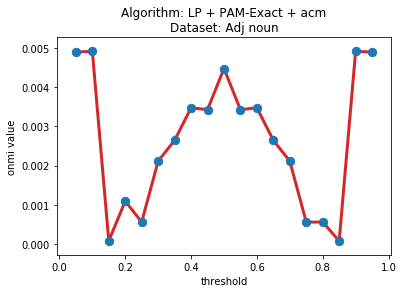

In [17]:
plot_all_params(algorithm = "LP + PAM-Exact + acm", dataset = "Adj noun", all_results = all_results['adj-noun'] )

### Adj-noun [ onmi: 0.00490969; thresould: 0.1 ] 

![adjnoun_ACM_kmd_2](../final_pictures/adjnoun_ACM_kmd_2_out.png)

# Politics Books #

In [18]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results['Politics Books'] = lp_experiment(clustersNumber=2, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/polbooks/polbooks.dat",
              groundTruth = "../datasets/polbooks/truth_polbooks.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True, verbose=False, lineGraph=True)

Output dir name: ../Results/lp_pmp_acm_polbooks
Output file name: ../Results/lp_pmp_acm_polbooks/pmp_polbooks_ACM_pmp_2.dat



Best ONMI: 0.464154 params: '-t 0.55'


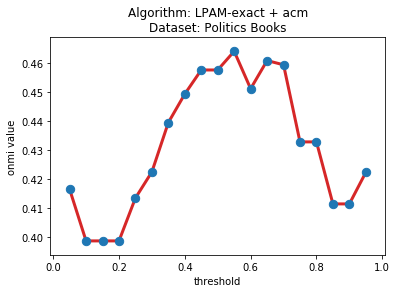

In [19]:
plot_all_params(algorithm = "LPAM-exact + acm", dataset = "Politics Books", all_results = all_results['Politics Books'])

![polbooks_ACM_pmp_2](../final_pictures/polbooks_ACM_pmp_2_out.png)
## Line Graph ##
![polbooks_ACM_pmp_2_line](../final_pictures/polbooks_ACM_pmp_2_out_line.png)

In [21]:
!pwd

/home/latna/aponom/clustering_edited/Scripts


# Syntetic Datasets #

### bench_30 ###

In [44]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results['bench_30'] = lp_experiment(clustersNumber=3, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_30/bench_30_network.dat",
              groundTruth = "../datasets/bench_30/bench_30_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True, lineGraph=True)

Output dir name: ../Results/lp_pmp_acm_bench_30
Output file name: ../Results/lp_pmp_acm_bench_30/pmp_bench_30_network_ACM_pmp_3.dat



Best ONMI: 0.931866 params: '-t 0.35000000000000003'


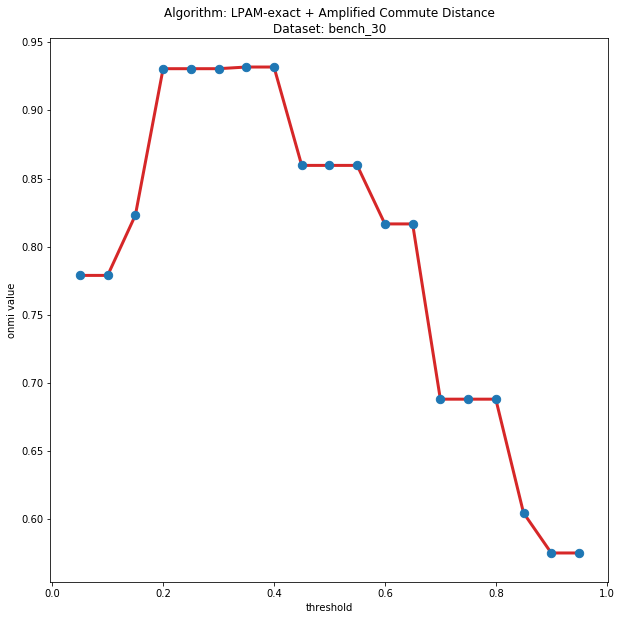

In [45]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_30", all_results = all_results['bench_30'])

![bench_30](../final_pictures/bench_30_network_ACM_pmp_3_out.png)
## Line Graph ##
![bench_30_line](../final_pictures/bench_30_network_ACM_pmp_3_out_line.png)

### bench_40 ###

In [46]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results['bench_40'] = lp_experiment(clustersNumber=4, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_40/bench_40_network.dat",
              groundTruth = "../datasets/bench_40/bench_40_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True, lineGraph=True)

Output dir name: ../Results/lp_pmp_acm_bench_40
Output file name: ../Results/lp_pmp_acm_bench_40/pmp_bench_40_network_ACM_pmp_4.dat



Best ONMI: 0.346589 params: '-t 0.35000000000000003'


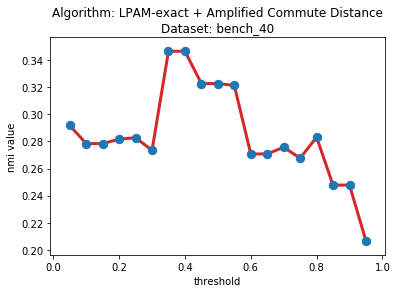

In [81]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_40", all_results = all_results)

![bench_50](../final_pictures/bench_40_network_ACM_pmp_4_out.png)
##  Line Graph ##
![bench_50](../final_pictures/bench_40_network_ACM_pmp_4_out_line.png)

### bench_50 ###

In [25]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results['bench_50'] = lp_experiment(clustersNumber=4, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_50/bench_50_network.dat",
              groundTruth = "../datasets/bench_50/bench_50_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True, lineGraph=True)

Output dir name: ../Results/lp_pmp_acm_bench_50
Output file name: ../Results/lp_pmp_acm_bench_50/pmp_bench_50_network_ACM_pmp_4.dat



Best ONMI: 0.845306 params: '-t 0.35000000000000003'


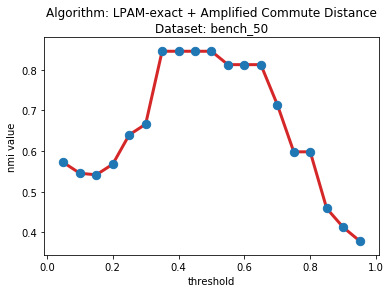

In [31]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_50", all_results = all_results)

![bench_50](../final_pictures/bench_50_network_ACM_pmp_4_out.png)
## Line Graph ##
![bench_50_line](../final_pictures/bench_50_network_ACM_pmp_4_out_line.png)

### bench_60 ###

In [24]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results['bench_60']  = lp_experiment(clustersNumber=6, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_60/bench_60_network.dat",
              groundTruth = "../datasets/bench_60/bench_60_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True, lineGraph=True)

Output dir name: ../Results/lp_pmp_acm_bench_60
Output file name: ../Results/lp_pmp_acm_bench_60/pmp_bench_60_network_ACM_pmp_6.dat



Best ONMI: 0.60211 params: '-t 0.55'


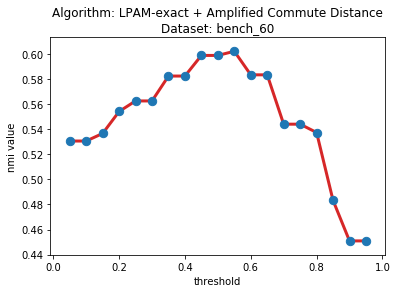

In [29]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_60", all_results = all_results)

![bench_60](../final_pictures/bench_60_network_ACM_pmp_6_out.png)
## Line Graph ##
![bench_60_line](../final_pictures/bench_60_network_ACM_pmp_6_out_line.png)

### bench_60 dense (mu = 0.25)###

In [23]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results['bench_60_dense'] = lp_experiment(clustersNumber=6, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_60_dense/bench_60_dense_network.dat",
              groundTruth = "../datasets/bench_60_dense/bench_60_dense_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True, lineGraph=True)

Output dir name: ../Results/lp_pmp_acm_bench_60_dense
Output file name: ../Results/lp_pmp_acm_bench_60_dense/pmp_bench_60_dense_network_ACM_pmp_6.dat



Best ONMI: 0.466922 params: '-t 0.2'


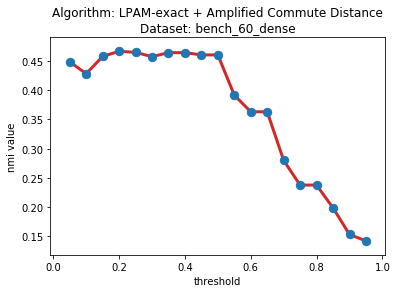

In [27]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_60_dense", all_results = all_results)

![bench_60](../final_pictures/bench_60_dense_network_ACM_pmp_6_out.png)
## Line Graph ##
![bench_60_line](../final_pictures/bench_60_dense_network_ACM_pmp_6_out_line.png)

In [68]:
for (dataset_name, all_results) in all_all_results:
    print(dataset_name)

school
karate


figure saved to: ../figures/lpam_exact_acm_onmi.tiff


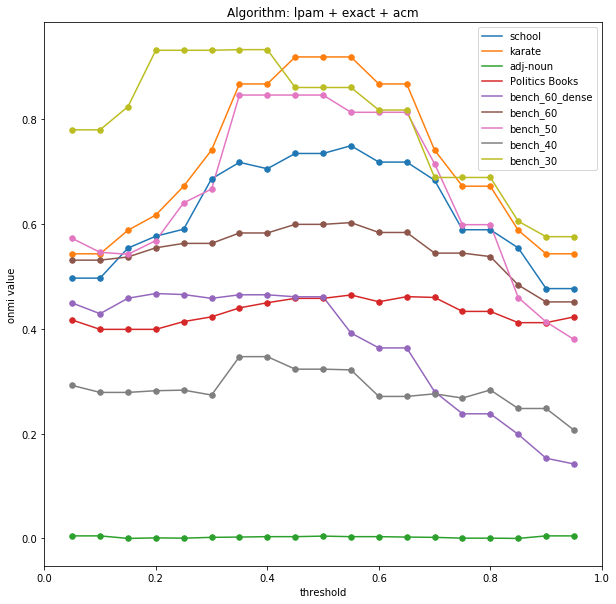

In [47]:
plt.rcParams["figure.figsize"] = (10,10)
fName = "lpam_exact_acm_onmi"
algorithm = "lpam + exact + acm"
for dataset_name, results in all_results.items():
    xdata=[]
    ydata=[]
    df = pd.DataFrame()
    for param, nmi in results.items():
        splited = param.split()
        xdata.append(float(splited[1]))
        ydata.append(nmi)
        df = df.append({'x': float(splited[1]), 'y': nmi}, ignore_index=True)

    plt.plot(xdata, ydata,  zorder=1)
    plt.scatter(xdata, ydata,s=30,zorder=2)


plt.legend(list(all_results.keys()))    
plt.xlabel('threshold')
plt.ylabel('onmi value')
plt.title('Algorithm: {}'.format(algorithm))

if (fName is not None):
    png1 = BytesIO()
    plt.savefig(png1, format='png', dpi=400)
    png2 = Image.open(png1)
    ffName = '../figures/{}.tiff'.format(fName)
    png2.save(ffName)
    png1.close()
    print("figure saved to: " + ffName)
plt.show()